<a href="https://colab.research.google.com/github/bharadwaj213/cs666student/blob/main/CS666_Assignment_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

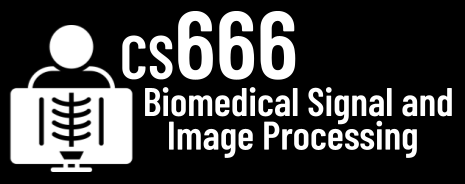
#Assignment 4

In [1]:
# NAME: INTURI SAI BHARADWAJ

In [2]:
# In this assignment, we will create a Random Forest classifier to detect pneumonia and covid in xrays!

In [3]:
# load numpy and matplotlib
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
# we are using mahotas again, so lets install it!
!pip install mahotas

In [5]:
# our imports include sklearn this time
import mahotas as mh
import os
from sklearn.ensemble import RandomForestClassifier

**Task 1:** Download, extract, and load the data! [15 Points]

In [6]:
# Please download this file: https://cs666.org/data/xray/ with the wget command!
# Note: Please use the forwarded dropbox link and change dl=0 to dl=1!
# This is a subset of the Kaggle Pneumonia + Covid Datasets!
!wget https://www.dropbox.com/s/2ca2889o2ql8n4e/xray.zip

--2024-04-05 03:48:47--  https://www.dropbox.com/s/2ca2889o2ql8n4e/xray.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/2ca2889o2ql8n4e/xray.zip [following]
--2024-04-05 03:48:47--  https://www.dropbox.com/s/raw/2ca2889o2ql8n4e/xray.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucbeea51511e937ca50d0f907d4e.dl.dropboxusercontent.com/cd/0/inline/CQaU2k-eaB5vmj9csdelkqvjD7FFOSmVglerdtC4C7kMCbJnM4-u4Hv7V85al8MBiCpeL9plTxoHBWcjImFiM7vVFwXd9yhnVvrQqsvLl-qTXbT0EhDUoBDzlvYxHx2tEoU/file# [following]
--2024-04-05 03:48:48--  https://ucbeea51511e937ca50d0f907d4e.dl.dropboxusercontent.com/cd/0/inline/CQaU2k-eaB5vmj9csdelkqvjD7FFOSmVglerdtC4C7kMCbJnM4-u4Hv7V85al8MBiCpeL9plTxoHBWcjImFiM7vVFwXd9yhnVvrQqsvLl-qTXbT0EhDUoBDzlvYxHx2tEoU/fil

In [7]:
# Run this code to extract the zip file and to create
# the folder structure of normal/, pneumonia/, and covid/ images.
# Each folder contains the first images of the Kaggle datasets.
import zipfile
with zipfile.ZipFile('xray.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

NORMAL_DIR = 'normal/'
PNEUMONIA_DIR = 'pneumonia/'
COVID_DIR = 'covid/'

In [8]:
# Here we load the first image from the normal dataset.
img = mh.imread(NORMAL_DIR + 'IM-0115-0001.jpeg')

In [9]:
# TODO: Please display this image and print the dimensions!

In [10]:
# TODO: YOUR CODE

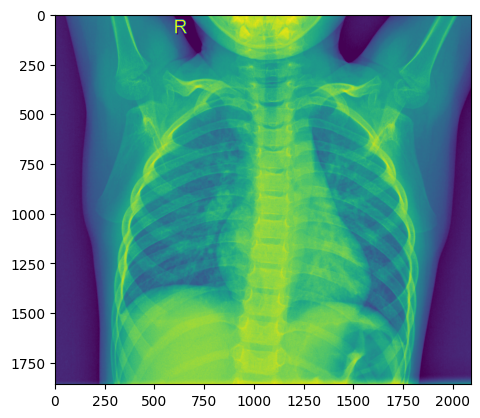

In [11]:
plt.imshow(img)

In [12]:
print(img.shape)

(1858, 2090)


**Task 2:** Let's do some data wrangling and more visualization! [30 Points]

In [13]:
folders = [NORMAL_DIR, PNEUMONIA_DIR, COVID_DIR]
data = [[],[],[]]

for f_index,f in enumerate( folders ):
  all_files = os.listdir( f )

  data[f_index] = np.zeros( (len(all_files), 300, 300), dtype=np.float32)

  for i in range(len(all_files)):
    loaded_image = mh.imread( f + '/' + all_files[i] )
    if loaded_image.ndim > 2:
      loaded_image = mh.colors.rgb2gray(loaded_image[:,:,:3])

    loaded_image = mh.imresize( loaded_image, (300, 300) )
    img_shape = loaded_image.shape

    data[f_index][ i, 0:img_shape[0], 0:img_shape[1] ] = loaded_image

In [14]:
# The two code blocks above perform 3 data wrangling operations.
# Which ones?
# Hint: The first two might be more obvious but the third one happens in the
# last line.
# TODO: Operation 1) The code iterates through the directories containing the image files.
# TODO: Operation 2) Each image is converted to grayscale using 'rgb2gray' and resized to 300x300 pixels.
# TODO: Operation 3) The processed images are stored in a NumPy array at their locations



In [15]:
# Now, let's look at the first 5 normal_images and the first 5 pneumonia_images.
# TODO: Please visualize multiple images at once.
# Hint: You can use one of the following answers from StackOverflow for this:
# https://stackoverflow.com/questions/41210823/using-plt-imshow-to-display-multiple-images

In [16]:
# TODO: YOUR CODE

<Figure size 640x480 with 0 Axes>

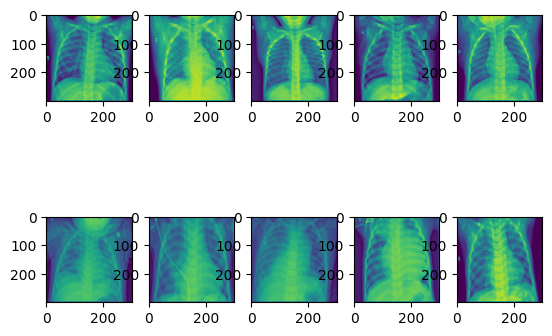

In [17]:
plt.figure()

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(2,5)

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
for i in range(5):
  axarr[0, i].imshow(data[0][i])
  axarr[1, i].imshow(data[1][i])



**Task 3:** Setup training and testing data. [15 Points]

In [18]:
# Any supervised machine learning algorithm requires disjunct sets of
# training and testing data.
#
# For each, we will create a balanced dataset that includes an equal number
# of normal xrays, pneumonia xrays, and covid xrays.
#
# The training data X_train will include 180 images (60 normal, 60 pneumonia, 60 covid).
# The testing data X_test will include the remaining 120 images (40 normal, 40 pneumonia, 40 covid).
#
# Supervised learning means that we tell the algorithm which image is normal
# and which image is pneumonia. For this, we need the y_train vector.
# The vector shall be 0 for a normal image, and 1 for a pneumonia, and 2 for a covid scan.

In [19]:
TRAINING_COUNT = 60

X_train = np.zeros( (TRAINING_COUNT * 3, 300*300 ), dtype=np.float32)
t_pos = 0

for d in data:
  for image in d[0:TRAINING_COUNT]:
    image = image.ravel() # flatten the image
    image /= image.max() # normalize the image
    X_train[t_pos] = image
    t_pos += 1

In [20]:
# TODO: Please create the y_train vector with 0 for a normal image,
# 1 for a pneumonia, and 2 for covid. This needs to a numpy array.


In [21]:

y_train = np.concatenate((np.zeros(TRAINING_COUNT), np.ones(TRAINING_COUNT), np.full(TRAINING_COUNT, 2)))




In [22]:
TESTING_COUNT = 40

X_test = np.zeros( (TESTING_COUNT * 3, 300*300 ), dtype=np.float32)
t_pos = 0

for d in data:
  for image in d[TRAINING_COUNT:TRAINING_COUNT+TESTING_COUNT]:
    image = image.ravel() # flatten the image
    image /= image.max() # normalize the image
    X_test[t_pos] = image
    t_pos += 1

In [23]:
# TODO: Please create the y_test vector with 0 for a normal image,
# 1 for a pneumonia, and 2 for covid. This needs to a numpy array.
y_test = np.concatenate((np.zeros(TESTING_COUNT), np.ones(TESTING_COUNT), np.full(TESTING_COUNT, 2)))



**Task 4:** Let's train and evaluate the Random Forest! [30 Points]

In [24]:
# Let's shuffle our training data.
p = np.random.permutation(len(X_train))
X_train = X_train[p]
y_train = y_train[p]

In [25]:
# With scikit-learn, we can easily set up a default Random Forest classifier.
clf = RandomForestClassifier()

In [26]:
# Now, we train the classifier with the training data and the training targets.
# We essentially show the classifier an image and tell whether the image is
# normal or pneumonia or covid.
fitted = clf.fit( X_train, y_train )

In [27]:
# TODO: In just a few sentences, please explain how the Random Forest works.

In [28]:
# TODO: Random Forest leverages multiple decision trees trained on random subsets of data to improve prediction accuracy and stability. It reduces overfitting, enhances generalization, and provides insight into feature importance in classification tasks

In [29]:
# After training, we can see how well the classifier predicts our testing data.
# The following command will return the classification accuracy.
clf.score( X_test, y_test )

0.9

In [30]:
# TODO: Is the classification accuracy good? And, are you surprised?

In [31]:
# TODO: Yes suprised that is high but we might better results if we train it with greater data size.

**Task 5:** Now, let's decrease the number of trees! [10 Points]

In [32]:
# How many trees are used in Task 4?

In [33]:
# TODO: YOUR ANSWER
print("Number of trees are:", clf.n_estimators)

Number of trees are: 100


In [34]:
# Now, please use a single tree and observe the testing performance.

In [35]:
# TODO: YOUR CODE

In [36]:
# Are you surprised?


In [37]:
# TODO: YOUR ANSWER
singletree_clf = RandomForestClassifier(n_estimators=1)
fitted_single_tree = singletree_clf.fit(X_train, y_train)
singletree_clf.score(X_test, y_test)

0.8166666666666667

In [38]:
#It's expected since we used a single decision tree to train the model.

**Bonus:** Let's take a closer look! [33 Points]

In [39]:
# Let's run the fitted classifier on the remaining covid images.
# You might have noticed that there are 199 covid images but we only used 100 so far.
# Please evaluate the classifier on the remaining (previously unseen) 99 covid images
# and check the performance.

In [40]:
# TODO: YOUR CODE AND YOUR ANSWER

covid_data = np.zeros((99, 300*300), dtype=np.float32)

for tpos, image in enumerate(data[2][100:199]):
    covid_data[tpos] = image.ravel() / image.max()

covid_y = np.array([2] * 99)

accuracy = clf.score(covid_data, covid_y)
print(f"Accuracy on unseen COVID images: {accuracy}")



Accuracy on unseen COVID images: 0.8888888888888888


In [41]:
# Can you figure out which images were misclassified?
# Hint: You can use predictions = clf.predict(X_test_covid_only) for this.
# Can you display them?
# Do you have an idea why these images were problematic?
#The primary reason could be that the data was unseen during training, leading to the model not being generalized enough. This lack of exposure to diverse examples may have limited the model's ability to accurately classify new, unseen images

Number of misclassified samples: 11
Indices of Misclassified samples: [ 3  5 11 16 26 35 42 47 53 61 81]


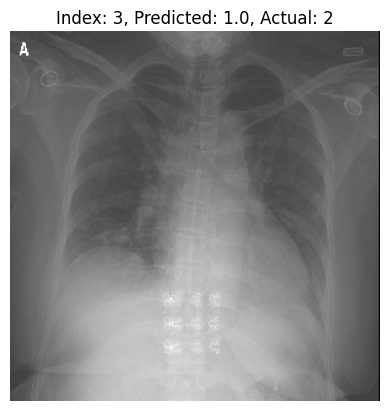

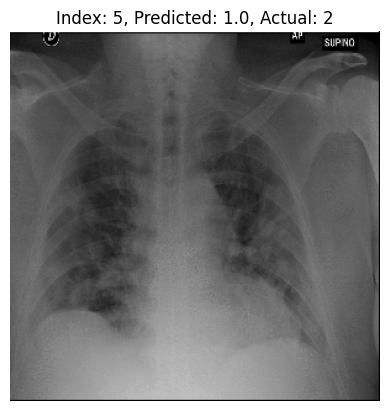

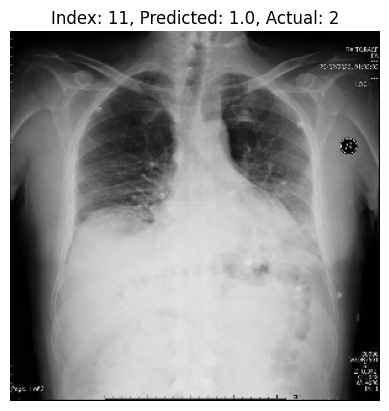

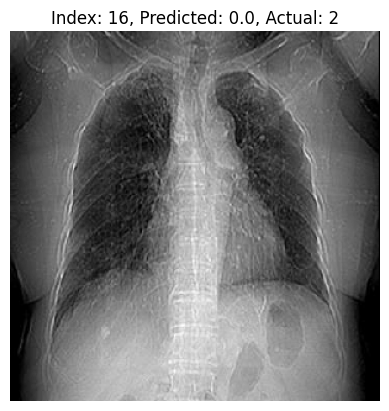

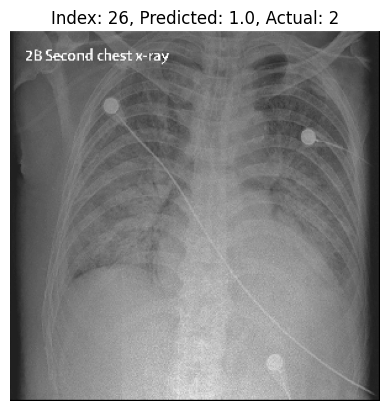

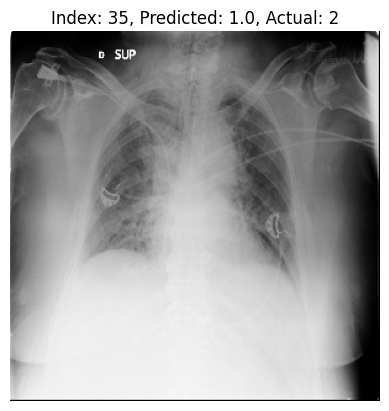

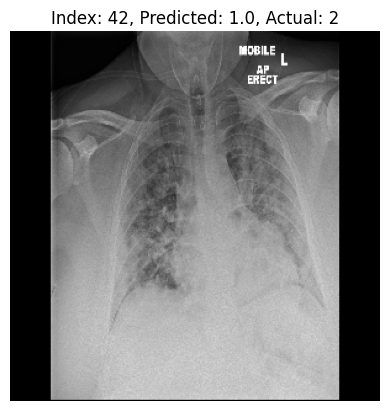

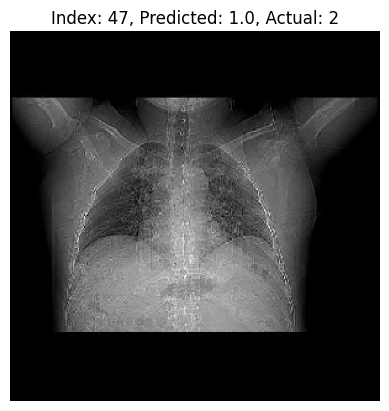

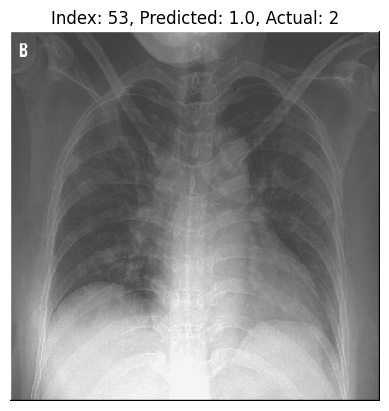

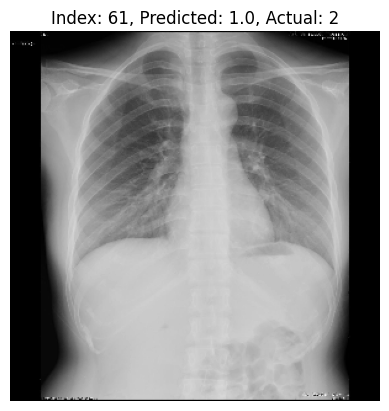

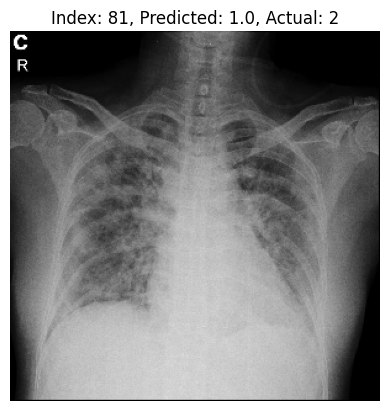

In [42]:
# TODO: YOUR CODE AND YOUR ANSWER

predicted_labels = clf.predict(covid_data)
incorrect_indices = np.where(predicted_labels != covid_y)[0]

print("Number of misclassified samples:", len(incorrect_indices))
print("Indices of Misclassified samples:", incorrect_indices)

incorrect_images = covid_data[incorrect_indices]
for index, image in enumerate(incorrect_images):
    plt.imshow(image.reshape(300, 300), cmap='gray')
    plt.title(f"Index: {incorrect_indices[index]}, Predicted: {predicted_labels[incorrect_indices[index]]}, Actual: 2")
    plt.axis('off')
    plt.show()





In [43]:
# Great job!!!
#           ___
#       _.-'   \
#      /        \
#     /          \
#    /            `.___
#   ( .--.)\/(,.--.    `-.
#   ,',-. \   / ,-.`.     )
#  ( /   \     /   \ )   / \
#   || .-|     |-. ||---'|  \
#  _|| | |     | | ||_   |   \
# /. \ |_|.---.|_| / ,\  | .^.\
# `.\ `--"     "--' /,'  |/
#   `>  _________ <'
# ,-' ,---.---.---. `-.
# `--'\    \j/    /`--'
#    `.\         /,'
#      \\_______//
#       `-------'       hjw